In [1208]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipyvolume as ipv
from matplotlib import cm
from scipy import stats
from matplotlib.gridspec import GridSpec
from scipy.signal import argrelmax
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from IPython.display import HTML
%matplotlib inline



In [1209]:
#Componentes como definidos no artigo de referência.
def L():
    return 12*10**(-3)

def C1():
    return 5.75*10**(-9)

def C2():
    return 21.32*10**(-9)

def Ga():
    return -0.879*10**(-3)

def Gb():
    return -0.4124*10**(-3)

def R0():
    return 30.86


In [1210]:
#Parâmetros adimensionais usados na EDO
def a_():
    return C2()/C1()

def b_(R):
    return C2()*R**2/L()
    
def c_(R):
    return R*Ga()
    
def d_(R):
    return R*Gb()

In [1211]:
def h(x, R):
    """
    Definição da curva de tensão por corrente do diodo de Chua. 
    _______________
        Recebe
    x: Variável adimensional relacionada à tensão.
    R: Resistência.
    _______________
        Retorna
    h(x,R): Variável adimensional relacionada à corrente.
    _______________
    """
    c = c_(R)
    d = d_(R)
    return d*x + 0.5*(c-d)*(abs(x+1) - abs(x-1))
        

In [1212]:
def ode(r, t, R):
    """
    Função que implementa a EDO adimensional. 
    _______________
        Recebe
    r: Array de três colunas com as variáveis da EDO.
    t: Tempo de integração.
    R: Resistência.
    _______________
        Retorna
    Vetor com as três EDOs.
    _______________
    """
    
    x, y, z = r
    return [a_()*(y-x-h(x, R)), x-y+z, -b_(R)*y - b_(R)*(R0()/R)*z]

In [1173]:
def soluciona_ode(R,T, dt):
    """
    Função que soluciona a EDO adimensional. 
    _______________
        Recebe
    R: Resistência.
    T: Máximo tempo de integração.
    dt: Passo do tempo de integração.
    _______________
        Retorna
    sol: Três colunas com as soluções.
    init: Condições iniciais.
    _______________
    """

    init = [4, 0.3, (c_(R) - d_(R))/(1+d_(R))] #Perto do ponto fixo P+
    t = np.arange(0, T, dt)
    sol = odeint(ode, init, t, args=(R,))

    return sol, init


In [1174]:
def plota_ode(R, T):
    """
    Função que plota a solução do circuito:
    (i) Visão osciloscópio.
    (ii) Visão 3D.
    _______________
        Recebe
    R: Resistência.
    T: Máximo tempo de integração.
    _______________
        Retorna
    Período da solução.
    _______________
    """
    
    dt = 0.05 
    sol, init = soluciona_ode(R, T, dt)
    t = np.arange(0, T, dt)
    tc = int(T/(1.5*dt))
    plt.style.use(["default"])

    plt.style.use(["seaborn-white"])

    fig = plt.figure()

    gs = GridSpec(4,4)

    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_x = fig.add_subplot(gs[0,0:3])
    ax_marg_y = fig.add_subplot(gs[1:4,3])

    ax_joint.plot(sol[tc:,0], sol[tc:,1], color = "navy")

    ax_marg_x.plot(t[tc:], sol[tc:,1], color = "teal")
    ax_marg_y.plot(sol[tc:,0], t[tc:], color = "teal")


    # Turn off tick labels on marginals
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel('$V_{1}$')
    ax_joint.set_ylabel('$V_{2}$')
    plt.title("$R = $" + str(R) + "$\Omega$")


    # Set labels on marginals
    ax_marg_y.set_xlabel('$V_{1}$')
    ax_marg_x.set_ylabel('$V_{2}$')
    #plt.savefig("images/periododoublecaos.pdf")
    plt.show()

    fig = plt.figure()
    
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(5, 150)
    ax.plot(sol[:,0], sol[:,1],sol[:,2], alpha = 0.7)
    ax.scatter([-(c_(R) - d_(R))/(1+d_(R))], [0], [(c_(R) - d_(R))/(1+d_(R))], color = "gray")
    ax.scatter([0.], [0.], [0.], color = "red")
    ax.scatter([(c_(R) - d_(R))/(1+d_(R))], [0], [-(c_(R) - d_(R))/(1+d_(R))], color = "gray")
    ax.text(0, 0, 0.5,"$P_{0}$", color = "red")
    

    ax.set_xlabel("$V_{1}$")
    ax.set_ylabel("$V_{2}$")
    ax.set_zlabel("$i_{L}$")
    
    aux = sol[tc:,0]
    return len(np.unique(np.around(aux[argrelmax(aux)], 2)))

## Soluções do circuito

<IPython.core.display.Javascript object>


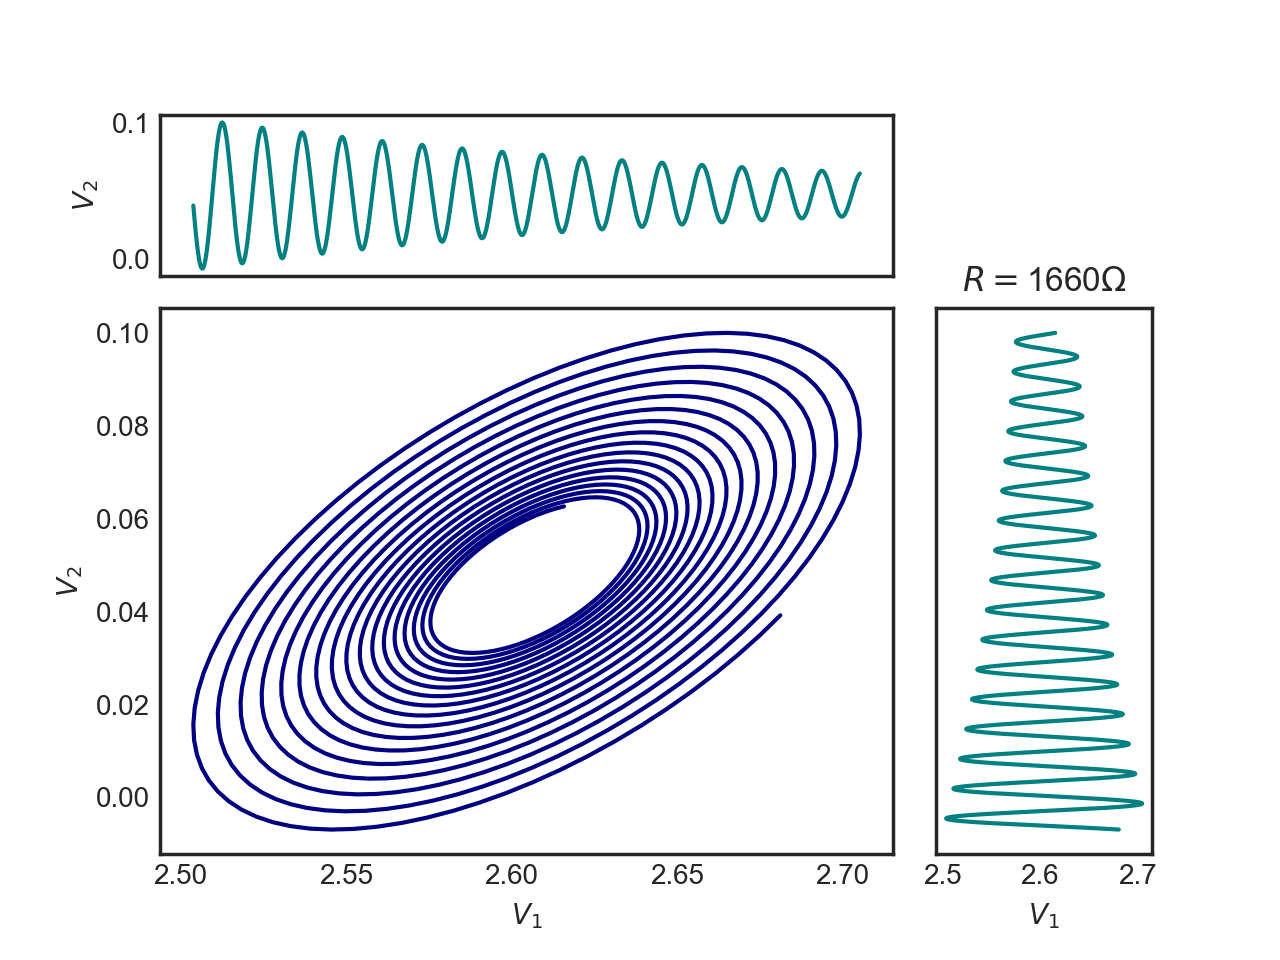

<IPython.core.display.Javascript object>


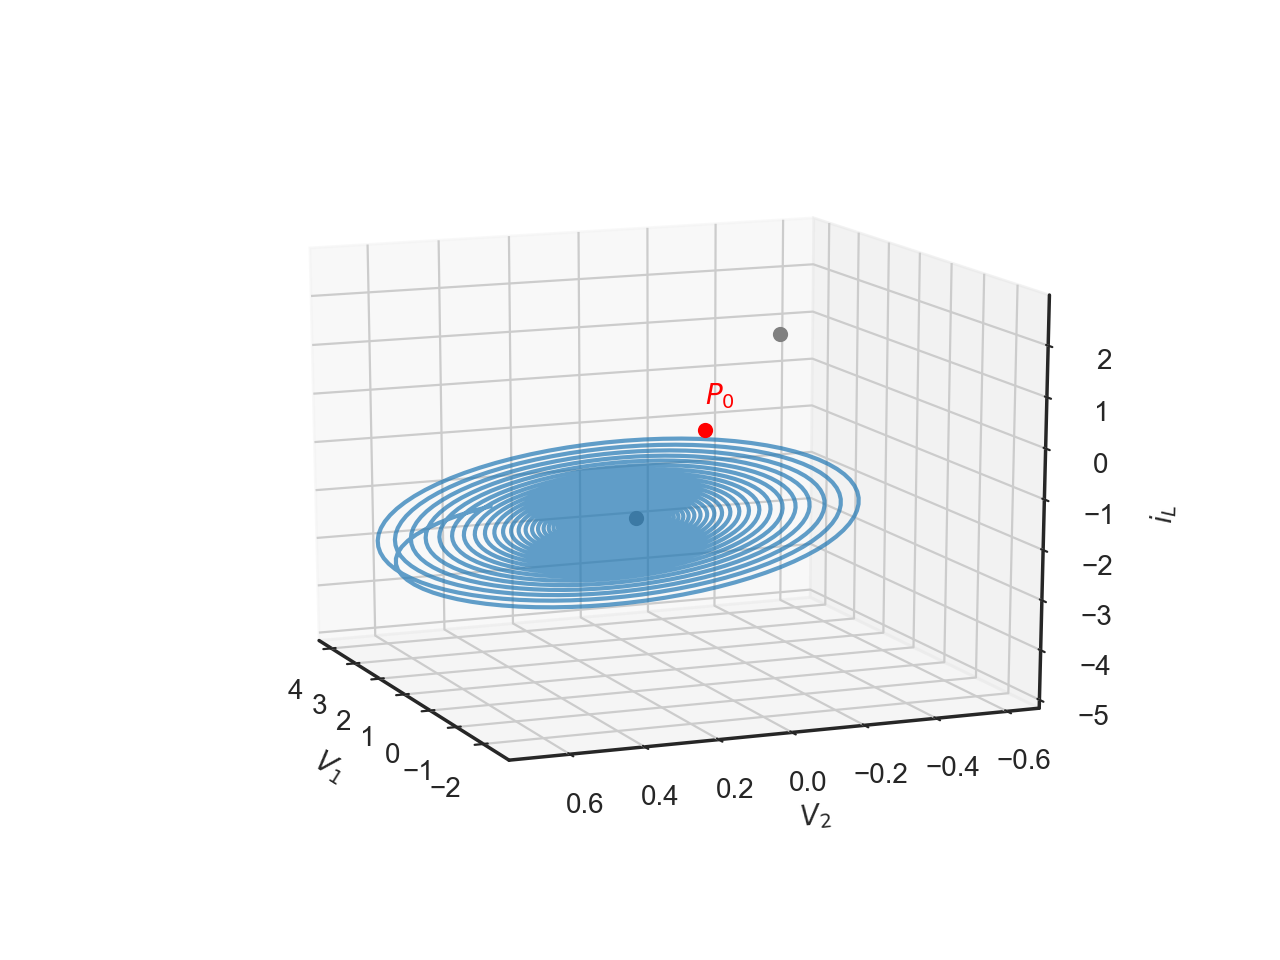

8

In [1183]:
plota_ode(1660, 200)

## Diagrama de Bifurcação

In [875]:
def bifurcacao(T):    
    """
    Função que plota o diagrama de bifurcações.
    _______________
        Recebe
    T: Máximo tempo de integração.
    _______________
        Retorna
        -------
    _______________
    """
    plt.style.use(["seaborn-white"])

    dt = 0.05
    t = np.arange(0, T, dt)
    tc = int(T/(1.5*dt))

    for R in np.arange(1590, 1550, -0.1):
        sol, init = soluciona_ode(R, T, dt)
        aux = sol[tc:,0]
        aux = np.unique(np.around(aux[argrelmax(aux)], 3))
        plt.scatter(np.full(len(aux), 1000/R), aux, marker = ".", color = "blue", s = 0.2)
    
    plt.xlabel("$G (mS)$")
    plt.ylabel("Máximos Locais")
    plt.savefig("diagrama.pdf")
    plt.show()
    

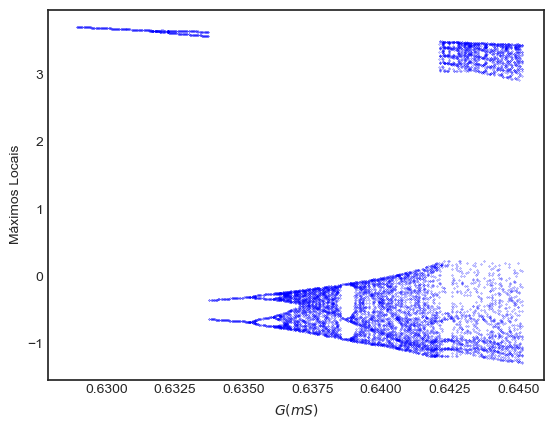

In [876]:
bifurcacao(500)

## Expoente de Lyapunov

In [922]:
def d(r1, r2):
    """
    Função que calcula a distância entre as trajetórias.
    _______________
        Recebe
    r1: Trajetória 1.
    r2: Trajetória 2.
    _______________
        Retorna
    Distância entre r1 e r2.
    _______________
    """
    return np.sqrt((r1[:,0]-r2[:,0])**2 +  (r1[:,1]-r2[:,1])**2  +  (r1[:,2]-r2[:,2])**2)

In [1186]:
def lyapunov(dy, R, T):
    """
    Função que calcula o expoente de Lyapunov.
    _______________
        Recebe
    dy: "Perturbação" à trajetória.
    R: Resistência.
    T: Tempo máximo de integração.
    _______________
        Retorna
    Trajetórias r e r2.
    _______________
    """
    
    dt = 0.05
    tc = int(T/(1.5*dt))
    
    init = [(d_(R) - c_(R))/(1+d_(R)), 0.0, (c_(R) - d_(R))/(1+d_(R))]
    init2 = [(d_(R) - c_(R))/(1+d_(R)), dy, (c_(R) - d_(R))/(1+d_(R))]

    t = np.arange(0, T, 0.1)
    r = odeint(ode, init, t, args=(R,))
    r2 = odeint(ode, init2, t, args=(R,))

    plt.style.use(['default'])

    fig = plt.figure()
    
    ax = fig.add_subplot(111, projection='3d')
    #ax.view_init(15, 110)
    ax.plot(r2[:,0], r2[:,1],r2[:,2], color = "crimson", alpha = 0.9)
    ax.plot(r[:,0], r[:,1],r[:,2], color = "royalblue", alpha = 0.9)


    

    ax.set_xlabel("$V_{1}$")
    ax.set_ylabel("$V_{2}$")
    ax.set_zlabel("$i_{L}$")
    plt.title("$\delta_{yi} = $" + str(dy))
    plt.savefig("Lyapunov1.pdf", bbox_inches = 'tight')
    plt.show()

    
    plt.style.use(['seaborn'])
    plt.yscale("log")
    plt.plot(t[700:], d(r,r2)[700:])
    slope, intercept, r_value, p_value, std_err = stats.linregress(t[700:], np.log(d(r,r2)[700:]))
    plt.plot(t[700:], np.e**(slope*t[700:] + intercept))
    plt.xlabel("$t$", fontsize=14)
    plt.ylabel("Distância", fontsize=14)
    plt.tick_params(labelsize=16)

    plt.savefig("Lyapunov.pdf")
    plt.show()
    print(slope)

    return r, r2


    

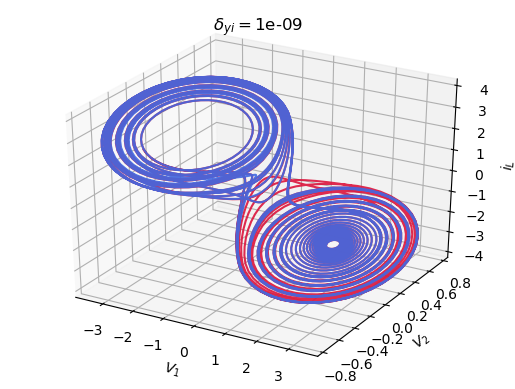

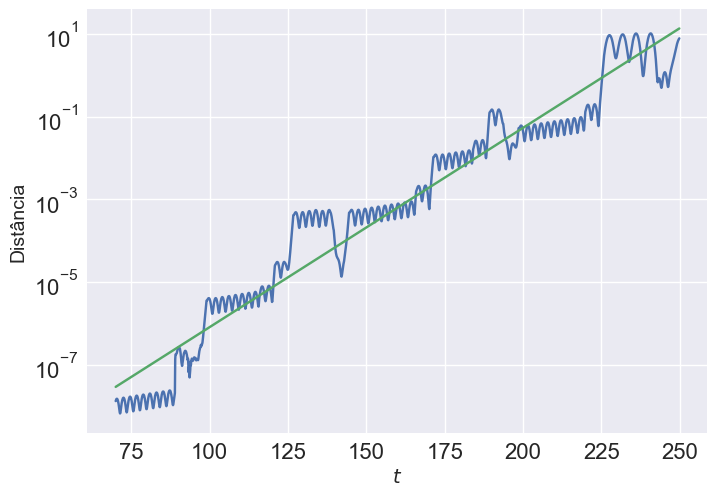

0.110719536409367


In [1228]:
r, r2 = lyapunov(0.000000001, 1546, 250)

## Animação do Caos. 

Animation size has reached 20998576 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


KeyboardInterrupt: 

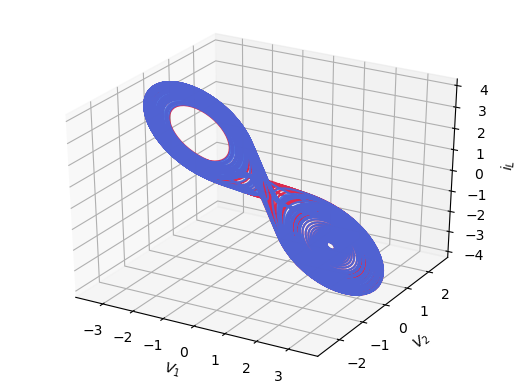

In [1227]:
plt.style.use(["default"])
def animate(i, r, r2):
    ax.cla()
    ax.axis('equal') 
    
    ax.plot(r2[:i,0], r2[:i,1],r2[:i,2], color = "crimson", alpha = 0.9)
    ax.plot(r[:i,0], r[:i,1],r[:i,2], color = "royalblue", alpha = 0.9)

    ax.set_xlabel("$V_{1}$")
    ax.set_ylabel("$V_{2}$")
    ax.set_zlabel("$i_{L}$")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ani = FuncAnimation(fig, animate, interval = 50, fargs = (r, r2), frames = len(r))
HTML(ani.to_jshtml())
